In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [1]:
import mpl_toolkits
mpl_toolkits.__path__.append('/usr/lib/python2.7/dist-packages/mpl_toolkits/basemap')
import os
import us
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize, rgb2hex
from matplotlib.patches import Polygon
from matplotlib.ticker import FuncFormatter
#from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sp
import seaborn as sns
from theano import shared

/home/leexa/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
%%bash
if [ ! -e ./st99_d00.dbf ];
then
    wget -q https://github.com/matplotlib/basemap/raw/master/examples/st99_d00.dbf
    wget -q https://github.com/matplotlib/basemap/raw/master/examples/st99_d00.shp
    wget -q https://github.com/matplotlib/basemap/raw/master/examples/st99_d00.shx
fi

In [4]:
SEED = 4260026 # from random.org, for reproducibility

np.random.seed(SEED)

In [5]:
def to_zero_indexed(col):
    return lambda df: (df[col] - 1).astype(np.int64)
DATA_PREFIX = 'http://www.princeton.edu/~jkastell/MRP_primer/'

survey_df = (pd.read_stata(os.path.join(DATA_PREFIX, 'gay_marriage_megapoll.dta'),
                           columns=['race_wbh', 'age_cat', 'edu_cat', 'female',
                                    'state_initnum', 'state', 'region_cat', 'region', 'statename',
                                    'poll', 'yes_of_all'])
               .dropna(subset=['race_wbh', 'age_cat', 'edu_cat', 'state_initnum'])
               .assign(state_initnum=to_zero_indexed('state_initnum'),
                       race_wbh=to_zero_indexed('race_wbh'),
                       edu_cat=to_zero_indexed('edu_cat'),
                       age_cat=to_zero_indexed('age_cat'),
                       region_cat=to_zero_indexed('region_cat')))

In [6]:
survey_df.head()
state_counts = survey_df.groupby('state').size()


In [15]:
us.states.lookup(unicode('Alaska')).abbr

u'AK'

NameError: name 'Basemap' is not defined

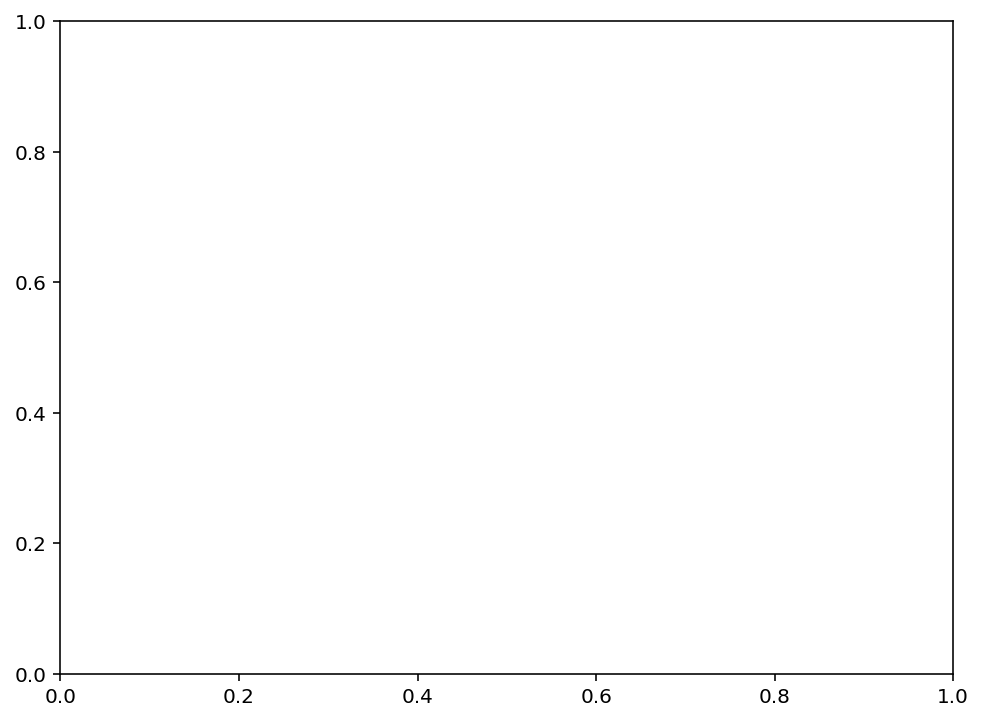

In [10]:
# respondants differ by states
def state_plot(state_data, cmap, norm, cbar=True, default=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    else:
        fig = plt.gcf()

    m = Basemap(llcrnrlon=-121, llcrnrlat=20,
                urcrnrlon=-62, urcrnrlat=51,
                projection='lcc',
                lat_1=32, lat_2=45, lon_0=-95)
    m.readshapefile('st99_d00', name='states', drawbounds=True)

    for state_info, state_seg in zip(m.states_info, m.states):
        if state_info['NAME'] == 'Alaska':
            state_seg = list(map(lambda xy: (0.35 * xy[0] + 1100000, 0.35 * xy[1] - 1300000), state_seg))
        elif state_info['NAME'] == 'Hawaii' and float(state_info['AREA']) > 0.005:
            state_seg = list(map(lambda xy: (xy[0] + 5100000, xy[1] - 1400000), state_seg))

        try:
            #print (state_info,state_seg)
            #print((state_info['NAME']))
            state_datum = state_data.loc[us.states.lookup(unicode(state_info['NAME'])).abbr]   
        except KeyError:
            state_datum = default
        if state_datum is not None:
            color = rgb2hex(cmap(norm(state_datum))) 

            poly = Polygon(state_seg, facecolor=color, edgecolor='#000000')
            ax.add_patch(poly)
    if cbar:
        cbar_ax = fig.add_axes([0.925, 0.25, 0.04, 0.5])
        mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm)
    else:
        cbar_ax = None
    return fig, ax, cbar_ax,'ok'
state_counts = survey_df.groupby('state').size()
fig, ax, cbar_ax,ok = state_plot(state_counts,
                              mpl.cm.binary,
                              Normalize(0, state_counts.max()),
                              default=None)
plt.savefig('test.png')
fig.show()

NameError: name 'Basemap' is not defined

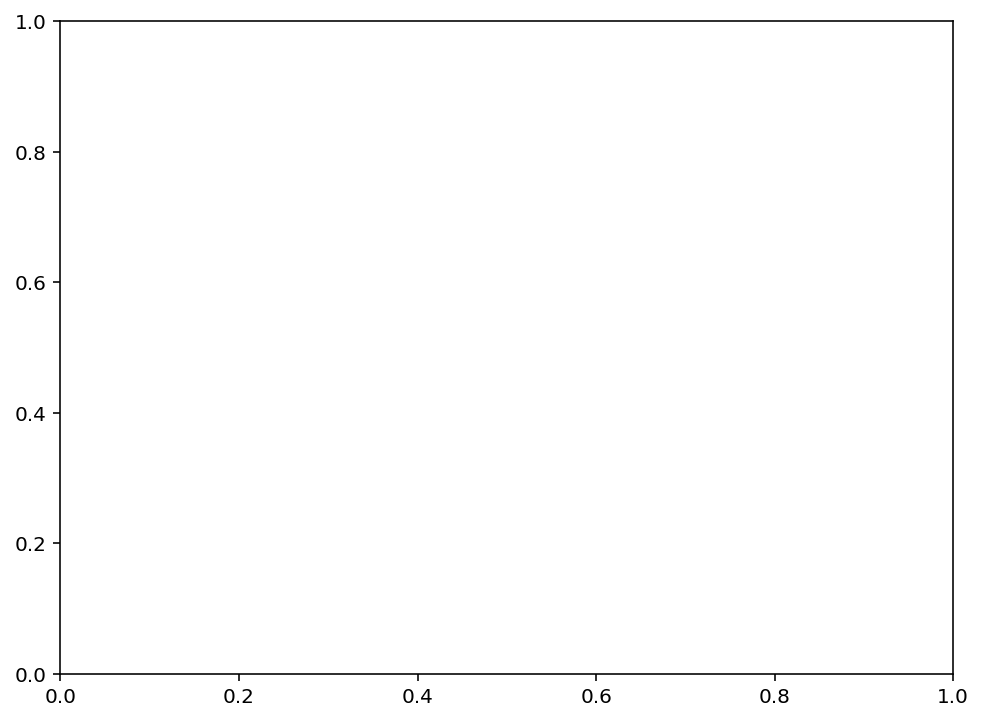

In [11]:
state_counts = survey_df.groupby('state').size()
fig, ax, cbar_ax,ok = state_plot(state_counts,
                              mpl.cm.binary,
                              Normalize(0, state_counts.max()),
                              default=None)
ax.set_title("Number of poll respondents");

In [12]:
disagg_p = (survey_df.groupby('state')
                     .yes_of_all
                     .mean())

NameError: name 'Basemap' is not defined

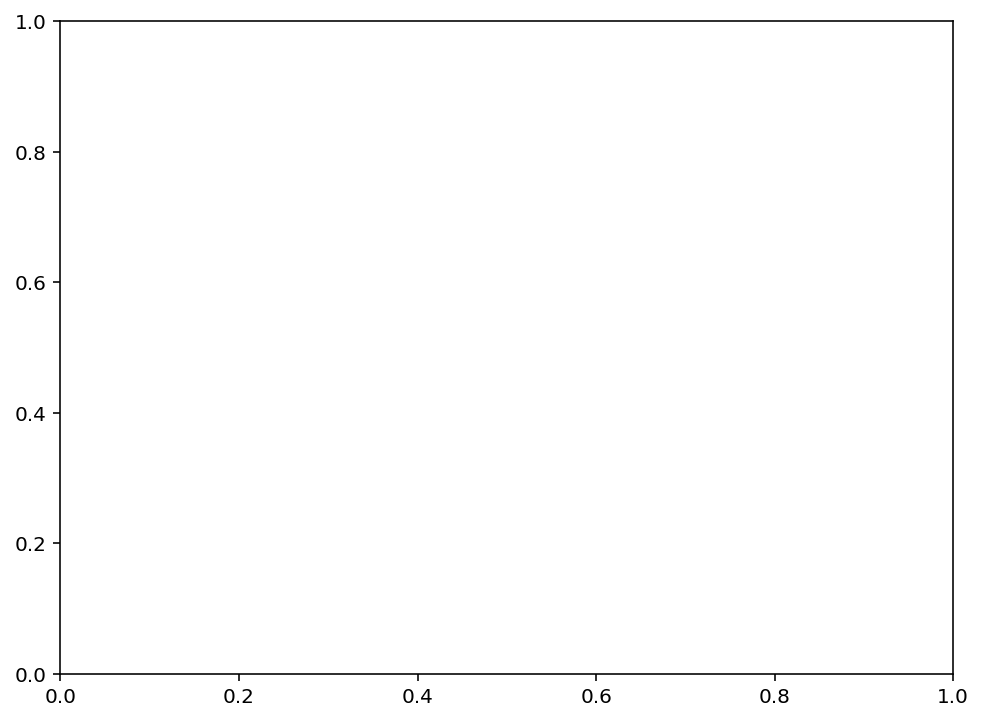

In [13]:
p_norm = Normalize(0., 0.6)
p_cmap = sns.diverging_palette(220, 10, as_cmap=True)

fig, ax, cbar_ax,ok = state_plot(disagg_p, p_cmap, p_norm)

p_formatter = FuncFormatter(lambda prop, _: '{:.1%}'.format(p_norm.inverse(prop)))
cbar_ax.yaxis.set_major_formatter(p_formatter);

ax.set_title("Disaggregation estimate of\nsupport for gay marriage in 2005");
plt.savefig('test2.png')

In [14]:
ax = (survey_df.groupby(['state', 'female', 'race_wbh'])
               .size()
               .unstack(level=['female', 'race_wbh'])
               .isnull()
               .sum()
               .unstack(level='female')
               .rename(index={0: 'White', 1: 'Black', 2: 'Hispanic'},
                       columns={0: 'Male', 1: 'Female'})
               .rename_axis('Race', axis=0)
               .rename_axis('Gender', axis=1)
               .plot(kind='bar', rot=0, figsize=(8, 6)))

ax.set_yticks(np.arange(0, 21, 5));
ax.set_ylabel("Number of states");

ax.set_title("States with no respondents");
print 'ok'
plt.savefig('test3.png')

SyntaxError: Missing parentheses in call to 'print'. Did you mean print('ok')? (<ipython-input-14-aa0e833a8f26>, line 17)

In [15]:
uniq_survey_df = (survey_df.groupby(['race_wbh', 'female', 'edu_cat', 'age_cat',
                                     'region_cat', 'state_initnum', 'poll'])
                           .yes_of_all
                           .agg({
                               'yes_of_all': 'sum',
                               'n': 'size'
                           })
                           .reset_index())

/home/leexa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


In [17]:
uniq_survey_df.shape[0] / survey_df.shape[0]

0.5824002523261316

In [18]:
def encode_gender_race(female, race_wbh):
    return (3 * female + race_wbh).values

def encode_age_edu(age, edu):
    return (4 * age + edu).values

In [19]:
gender_race = encode_gender_race(uniq_survey_df.female, uniq_survey_df.race_wbh)
n_gender_race = np.unique(gender_race).size

age = uniq_survey_df.age_cat.values
n_age = np.unique(age).size

edu = uniq_survey_df.edu_cat.values
n_edu = np.unique(edu).size

age_edu = encode_age_edu(uniq_survey_df.age_cat, uniq_survey_df.edu_cat)
n_age_edu = np.unique(age_edu).size

poll, poll_map = uniq_survey_df.poll.factorize()
n_poll = poll_map.size

region = uniq_survey_df.region_cat.values
n_region = np.unique(region).size

state = uniq_survey_df.state_initnum.values
n_state = 51

n = uniq_survey_df.n.values
yes_of_all = uniq_survey_df.yes_of_all.values

In [20]:
STATE_URL = 'http://www.princeton.edu/~jkastell/MRP_primer/state_level_update.dta'

state_df = (pd.read_stata(STATE_URL,
                          columns=['sstate_initnum', 'sstate',
                                   'p_evang', 'p_mormon', 'kerry_04'])
              .rename(columns={'sstate_initnum': 'state_initnum', 'sstate': 'state'})
              .assign(state_initnum=to_zero_indexed('state_initnum'),
                      p_relig=lambda df: df.p_evang + df.p_mormon))
state_kerry = sp.special.logit(state_df.kerry_04.values / 100.)
state_relig = sp.special.logit(state_df.p_relig.values / 100.)

In [23]:
print (state_df.head())
print (state_kerry)
print (state_df.kerry_04.values / 100.)

   state_initnum state    p_evang  p_mormon   kerry_04    p_relig
0              0    AK  12.440000  3.003126  35.500000  15.443126
1              1    AL  40.549999  0.458273  36.799999  41.008274
2              2    AR  43.070000  0.560113  44.599998  43.630112
3              3    AZ   9.410000  4.878735  44.400002  14.288734
4              4    CA   7.160000  1.557627  54.299999   8.717627
[-0.5971325  -0.5408064  -0.21684584 -0.22494373  0.17242591 -0.12014428
  0.17242591  2.1113343   0.13621034 -0.11613048 -0.34745377  0.16034272
 -0.03200272 -0.83305264  0.19259298 -0.43471918 -0.5494156  -0.41798085
 -0.3145684   0.48530596  0.2371047   0.14424965  0.04800928  0.04400703
 -0.15631762 -0.4138054  -0.46415764 -0.25741208 -0.5971325  -0.72178507
  0.00800023  0.11613055 -0.03600393 -0.08404952  0.33921573 -0.05201171
 -0.6455192   0.05601461  0.03600385  0.3805263  -0.3681008  -0.47260445
 -0.30228078 -0.4810679  -1.0459687  -0.18048827  0.35983294  0.11211724
 -0.01200015 -0.2736

In [24]:
CENSUS_URL = 'http://www.princeton.edu/~jkastell/MRP_primer/poststratification%202000.dta'

census_df = (pd.read_stata(CENSUS_URL)
               .rename(columns=lambda s: s.lstrip('c_').lower())
               .assign(race_wbh=to_zero_indexed('race_wbh'),
                       edu_cat=to_zero_indexed('edu_cat'),
                       age_cat=to_zero_indexed('age_cat')))

In [25]:
census_df.head()

,race_wbh,age_cat,edu_cat,female,state,freq,freq_state,percent_state,region
0,0,0,0,0,AK,467,21222.0,0.022005,west
1,0,1,0,0,AK,377,21222.0,0.017765,west
2,0,2,0,0,AK,419,21222.0,0.019744,west
3,0,3,0,0,AK,343,21222.0,0.016162,west
4,0,0,1,0,AK,958,21222.0,0.045142,west


In [26]:
state_df = (pd.merge(
                pd.merge((survey_df.groupby('region')
                                   .region_cat
                                   .first()
                                   .reset_index()),
                          (census_df[['state', 'region']].drop_duplicates()),
                          on='region')[['state', 'region_cat']],
                 state_df, on='state')
               .set_index('state_initnum')
               .sort_index())

In [27]:
state_df.head()

,state,region_cat,p_evang,p_mormon,kerry_04,p_relig
state_initnum,,,,,,
0,AK,3,12.440000,3.003126,35.500000,15.443126
1,AL,2,40.549999,0.458273,36.799999,41.008274
2,AR,2,43.070000,0.560113,44.599998,43.630112
3,AZ,3,9.410000,4.878735,44.400002,14.288734
4,CA,3,7.160000,1.557627,54.299999,8.717627


In [28]:
state_region = state_df.region_cat.values

In [29]:
gender_race_ = shared(gender_race)
age_ = shared(age)
edu_ = shared(edu)
age_edu_ = shared(age_edu)
poll_ = shared(poll)
state_ = shared(state)
use_poll_ = shared(1)
n_ = shared(n)

In [30]:
def hierarchical_normal(name, shape, μ=0.):
    Δ = pm.Normal('Δ_{}'.format(name), 0., 1., shape=shape)
    σ = pm.HalfCauchy('σ_{}'.format(name), 5.)
    
    return pm.Deterministic(name, μ + Δ * σ)